# AI 감정 인식 모델 학습 (LR Scheduler + Long Training)

이 노트북은 **MediaPipe FaceMesh**를 사용하여 얼굴 랜드마크를 추출하고, PyTorch를 사용하여 감정 분류 모델을 학습합니다.

**주요 변경 사항:**
- 2개의 GPU 활용 (DataParallel)
- **외부 데이터 로더(ML/data_loader.py) 사용**: 주피터 노트북에서 멀티프로세싱 오류를 해결하기 위해 함수 분리
- **학습률 스케줄러 (Learning Rate Scheduler)**: 학습이 진행될수록 학습률을 줄여 오버슈팅 방지 및 안정성 확보
- **초장기 학습**: **1000 Epochs**로 설정하여 최대한의 성능을 끌어냅니다.
- 학습 진행 상황(Loss, Accuracy) 실시간 시각화

In [26]:
import zipfile
import cv2
import mediapipe as mp
import numpy as np
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor

# [중요] 외부 모듈에서 함수 불러오기 (Jupyter 멈춤/크래시 방지)
# 만약 여기서 에러나면 Kernel -> Restart 하세요
from data_loader import process_single_image

# 시각화 설정
%matplotlib inline

# GPU 설정 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.device_count() > 1:
    print(f"Detected {torch.cuda.device_count()} GPUs! Using DataParallel.")


Using device: cuda
Detected 2 GPUs! Using DataParallel.


In [27]:
# ============================
# 설정 변수
# ============================

# 데이터셋 경로 
BASE_DIR = r"c:\Users\ldy34\Desktop\Face\video"
TRAIN_DIR = os.path.join(BASE_DIR, "Training")

# 하이퍼파라미터 (대폭 증가)
BATCH_SIZE = 128
EPOCHS = 1000  # 150 -> 1000 (극한 학습)
LEARNING_RATE = 0.001
NUM_WORKERS = os.cpu_count() or 4

# 학습할 파일 목록 자동 검색
zip_files = glob.glob(os.path.join(TRAIN_DIR, "*.zip"))
print(f"Found {len(zip_files)} zip files.")

Found 35 zip files.


In [28]:
# ============================
# 데이터 로딩 함수 (외부 함수 사용)
# ============================

def extract_landmarks_parallel(zip_path, label, max_samples=10000):
    if not os.path.exists(zip_path):
        print(f"\n[Error] File not found: {zip_path}")
        return [], []

    print(f"\n[{os.path.basename(zip_path)}] Reading Zip...")
    
    # 1. ZIP 파일 읽기 (메인 스레드)
    image_data_list = []
    with zipfile.ZipFile(zip_path, 'r') as z:
        file_list = [f for f in z.namelist() if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        use_count = min(len(file_list), max_samples)
        target_files = file_list[:use_count]
        
        # 이미지를 메모리에 로드 (병렬 처리를 위해)
        for img_name in target_files:
            with z.open(img_name) as f:
                image_data_list.append((f.read(), label))
    
    print(f"  - Loaded {len(image_data_list):,} images. Starting CPU Parallel Processing...")

    # 2. 병렬 처리 실행
    data = []
    labels = []
    
    # 중요: process_single_image 함수는 별도 파일(data_loader.py)에 있어야 윈도우 주피터가 찾을 수 있음
    with ProcessPoolExecutor(max_workers=NUM_WORKERS) as executor:
        results = list(tqdm(executor.map(process_single_image, image_data_list), total=len(image_data_list), desc="  Processing"))
        
        for res in results:
            if res is not None:
                d, l = res
                data.append(d)
                labels.append(l)
                
    print(f"  -> Successfully extracted: {len(data):,} samples")
    return data, labels

In [21]:
# 데이터 로드 실행
if __name__ == '__main__':
    X = []
    y = []

    print("Starting Parallel Data Extraction...")
    
    # ZIP 파일 순회하며 데이터 추출
    MAX_SAMPLES_PER_ZIP = 2000  # 테스트를 위해 2000개씩만 (필요시 늘리세요)
    
    for zip_path in zip_files:
        filename = os.path.basename(zip_path)
        if "중립" in filename or "Neutral" in filename:
            label = 0
        elif "불안" in filename or "Anxiety" in filename:
            label = 1
        else:
            continue
            
        d, l = extract_landmarks_parallel(zip_path, label, max_samples=MAX_SAMPLES_PER_ZIP)
        X.extend(d)
        y.extend(l)

    X = np.array(X)
    y = np.array(y)

    print(f"\nTotal Dataset Size: {len(X):,} samples")

Starting Parallel Data Extraction...

[[라벨]EMOIMG_불안_TRAIN.zip] Reading Zip...
  - Loaded 0 images. Starting CPU Parallel Processing...


  Processing: 0it [00:00, ?it/s]


  -> Successfully extracted: 0 samples

[[라벨]EMOIMG_중립_TRAIN.zip] Reading Zip...
  - Loaded 0 images. Starting CPU Parallel Processing...


  Processing: 0it [00:00, ?it/s]

  -> Successfully extracted: 0 samples

[[원천]EMOIMG_불안_TRAIN_01.zip] Reading Zip...


  - Loaded 2,000 images. Starting CPU Parallel Processing...


  Processing: 100%|██████████| 2000/2000 [00:31<00:00, 64.00it/s] 


  -> Successfully extracted: 2,000 samples

[[원천]EMOIMG_불안_TRAIN_02.zip] Reading Zip...
  - Loaded 2,000 images. Starting CPU Parallel Processing...


  Processing: 100%|██████████| 2000/2000 [00:33<00:00, 59.80it/s] 


  -> Successfully extracted: 2,000 samples

[[원천]EMOIMG_불안_TRAIN_03.zip] Reading Zip...
  - Loaded 2,000 images. Starting CPU Parallel Processing...


  Processing: 100%|██████████| 2000/2000 [00:29<00:00, 67.69it/s] 


  -> Successfully extracted: 2,000 samples

[[원천]EMOIMG_불안_TRAIN_04.zip] Reading Zip...
  - Loaded 2,000 images. Starting CPU Parallel Processing...


  Processing: 100%|██████████| 2000/2000 [00:30<00:00, 65.81it/s] 


  -> Successfully extracted: 2,000 samples

[[원천]EMOIMG_중립_TRAIN_01.zip] Reading Zip...
  - Loaded 2,000 images. Starting CPU Parallel Processing...


  Processing: 100%|██████████| 2000/2000 [00:30<00:00, 64.61it/s] 


  -> Successfully extracted: 2,000 samples

[[원천]EMOIMG_중립_TRAIN_02.zip] Reading Zip...
  - Loaded 2,000 images. Starting CPU Parallel Processing...


  Processing: 100%|██████████| 2000/2000 [00:33<00:00, 59.54it/s] 


  -> Successfully extracted: 2,000 samples

[[원천]EMOIMG_중립_TRAIN_03.zip] Reading Zip...
  - Loaded 2,000 images. Starting CPU Parallel Processing...


  Processing: 100%|██████████| 2000/2000 [00:29<00:00, 67.30it/s] 


  -> Successfully extracted: 2,000 samples

[[원천]EMOIMG_중립_TRAIN_04.zip] Reading Zip...
  - Loaded 2,000 images. Starting CPU Parallel Processing...


  Processing: 100%|██████████| 2000/2000 [00:30<00:00, 66.06it/s] 


  -> Successfully extracted: 2,000 samples

Total Dataset Size: 16,000 samples


In [29]:
# 데이터 분할 및 텐서 변환
if len(X) > 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Tensor 변환
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.long)

    # DataLoader
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_dataset = TensorDataset(X_test_t, y_test_t)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Train Set: {len(X_train):,} | Test Set: {len(X_test):,}")
else:
    print("No data loaded. Check paths.")

Train Set: 12,800 | Test Set: 3,200


In [30]:
# 모델 정의
class EmotionMLP(nn.Module):
    def __init__(self, input_size):
        super(EmotionMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            
            nn.Linear(128, 2) # Neutral, Anxious
        )
    
    def forward(self, x):
        return self.network(x)

model = EmotionMLP(X_train.shape[1]).to(device)

# Multi-GPU 적용
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# [New] Learning Rate Scheduler 업데이트
# 1000 에포크 기준: 200, 400, 600, 800 (총 4~5번 감소)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

print("Model Initialized with LR Scheduler (1000 Epochs).")

Model Initialized with LR Scheduler (1000 Epochs).


In [31]:
# 학습 루프
history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'lr': []}

print("Target Epochs:", EPOCHS)
best_acc = 0.0

for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    # 스케줄러 업데이트 (에포크 끝날 때마다)
    current_lr = scheduler.get_last_lr()[0]
    scheduler.step()
    
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = correct / total
    
    # --- Validation (Test) ---
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += y_batch.size(0)
            correct_test += (predicted == y_batch).sum().item()
            
    epoch_test_loss = test_loss / len(test_loader)
    epoch_test_acc = correct_test / total_test
    
    # 기록 저장
    history['train_loss'].append(epoch_train_loss)
    history['test_loss'].append(epoch_test_loss)
    history['train_acc'].append(epoch_train_acc)
    history['test_acc'].append(epoch_test_acc)
    history['lr'].append(current_lr)
    
    # 최고 모델 저장
    if epoch_test_acc > best_acc:
        best_acc = epoch_test_acc
        torch.save(model.state_dict(), 'emotion_model_scheduler_best.pth')
    
    # 50 에포크마다 출력 (로그 너무 많지 않게)
    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] LR: {current_lr:.6f} | "
              f"T-Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
              f"V-Loss: {epoch_test_loss:.4f} Acc: {epoch_test_acc:.4f}")

print(f"Training Complete. Best Validation Accuracy: {best_acc:.4f}")

Target Epochs: 1000


c:\Users\ldy34\Desktop\Face\.venv\Lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn("PyTorch is not compiled with NCCL support")


Epoch [50/1000] LR: 0.001000 | T-Loss: 0.3707 Acc: 0.8384 | V-Loss: 0.5513 Acc: 0.7113
Epoch [100/1000] LR: 0.001000 | T-Loss: 0.3738 Acc: 0.8373 | V-Loss: 0.4883 Acc: 0.7797
Epoch [150/1000] LR: 0.001000 | T-Loss: 0.3640 Acc: 0.8413 | V-Loss: 0.3751 Acc: 0.8566
Epoch [200/1000] LR: 0.001000 | T-Loss: 0.3927 Acc: 0.8282 | V-Loss: 0.4159 Acc: 0.8247
Epoch [250/1000] LR: 0.000500 | T-Loss: 0.3772 Acc: 0.8373 | V-Loss: 0.3994 Acc: 0.8206
Epoch [300/1000] LR: 0.000500 | T-Loss: 0.3765 Acc: 0.8377 | V-Loss: 0.5044 Acc: 0.7297
Epoch [350/1000] LR: 0.000500 | T-Loss: 0.3705 Acc: 0.8435 | V-Loss: 0.3699 Acc: 0.8462
Epoch [400/1000] LR: 0.000500 | T-Loss: 0.3620 Acc: 0.8474 | V-Loss: 0.4391 Acc: 0.8313
Epoch [450/1000] LR: 0.000250 | T-Loss: 0.3579 Acc: 0.8470 | V-Loss: 0.4085 Acc: 0.8409
Epoch [500/1000] LR: 0.000250 | T-Loss: 0.3514 Acc: 0.8521 | V-Loss: 0.3793 Acc: 0.8481
Epoch [550/1000] LR: 0.000250 | T-Loss: 0.3553 Acc: 0.8523 | V-Loss: 0.4825 Acc: 0.8034
Epoch [600/1000] LR: 0.000250 | T

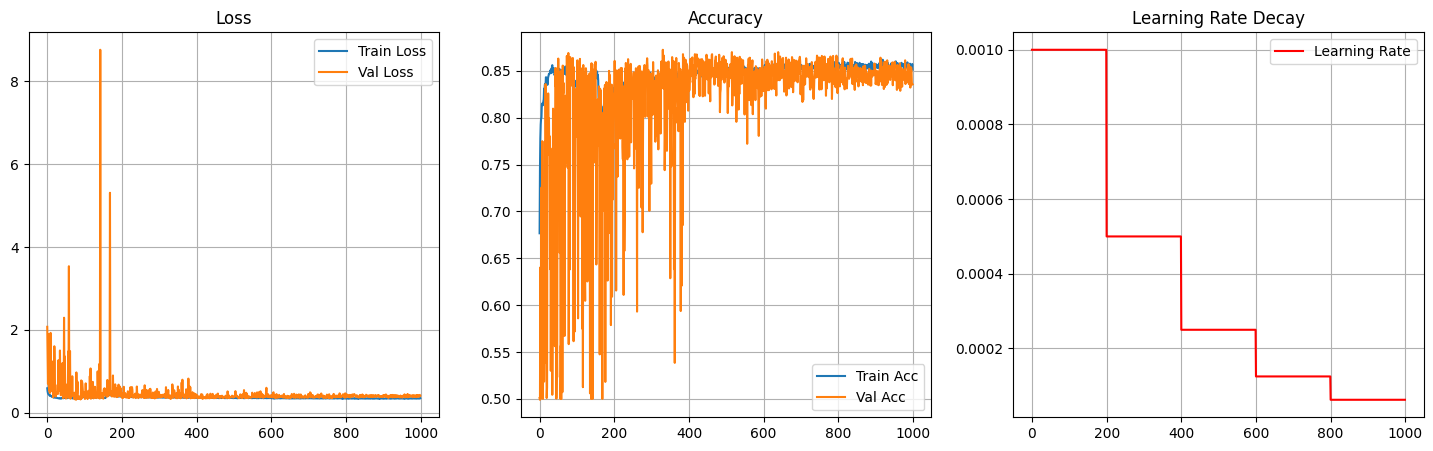

In [32]:
# 결과 시각화
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['test_acc'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history['lr'], label='Learning Rate', color='red')
plt.title('Learning Rate Decay')
plt.legend()
plt.grid(True)

plt.show()

In [33]:
# 모델 저장
model.eval()
with torch.no_grad():
    X_test_device = X_test_t.to(device)
    outputs = model(X_test_device)
    _, predicted = torch.max(outputs, 1)
    y_pred = predicted.cpu().numpy()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Anxious']))

print("Final model saved as 'emotion_model_scheduler_best.pth'")


Classification Report:
              precision    recall  f1-score   support

     Neutral       0.77      0.96      0.85      1600
     Anxious       0.95      0.71      0.81      1600

    accuracy                           0.84      3200
   macro avg       0.86      0.84      0.83      3200
weighted avg       0.86      0.84      0.83      3200

Final model saved as 'emotion_model_scheduler_best.pth'
